# Logistic Regression

This notebook implements a Logistic Regression classifier for automated essay scoring using TF-IDF features from both prompts and essays.

## Key Findings

After hyperparameter tuning, the best model achieved a test accuracy of 35.68%, slightly outperforming the linear regression approach in classification tasks. Despite this improvement, the classification report shows that the model struggles with lower support classes and suggests room for enhancement, particularly in capturing nuanced language features.

## Import and Setup

---

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk
import re
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Data Import

---

In [2]:
df_train = pd.read_csv("../data/clean_train.csv")
df_test = pd.read_csv("../data/clean_test.csv")

In [3]:
df_train.shape

(9048, 14)

## Oversampling

---

Before oversampling:
Train shape: (9048, 14)
Train class distribution:
band_score
4.0     849
4.5     556
5.0     540
5.5     888
6.0    1375
6.5    1493
7.0    1315
7.5    1138
8.0     488
8.5     406
Name: count, dtype: int64


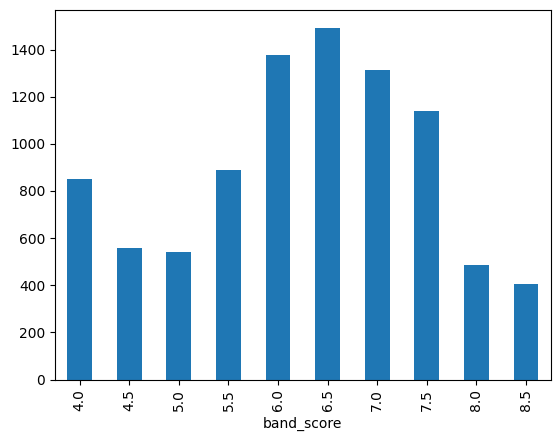

In [4]:
band_counts = df_train["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")
print("Before oversampling:")
print(f"Train shape: {df_train.shape}")
print(
    f"Train class distribution:\n{df_train['band_score'].value_counts().sort_index()}"
)

In [5]:
def random_oversample(df, target_column, random_state=42):
    """
    Randomly oversample minority classes to match the majority class
    """
    np.random.seed(random_state)

    # Get class counts
    class_counts = df["band_score"].value_counts()
    max_count = class_counts.max()

    oversampled_dfs = []

    for class_value in class_counts.index:
        class_df = df[df["band_score"] == class_value]
        current_count = len(class_df)

        if current_count < max_count:
            # Calculate how many more samples we need
            needed_samples = max_count - current_count

            # Randomly sample with replacement
            additional_samples = class_df.sample(
                n=needed_samples, replace=True, random_state=random_state
            )

            # Combine original and additional samples
            class_df_oversampled = pd.concat(
                [class_df, additional_samples], ignore_index=True
            )
        else:
            class_df_oversampled = class_df

        oversampled_dfs.append(class_df_oversampled)

    # Combine all classes
    result_df = pd.concat(oversampled_dfs, ignore_index=True)

    # Shuffle the dataset
    result_df = result_df.sample(frac=1, random_state=random_state).reset_index(
        drop=True
    )

    return result_df


After oversampling:
Train shape: (14930, 14)
Train class distribution:
band_score
4.0    1493
4.5    1493
5.0    1493
5.5    1493
6.0    1493
6.5    1493
7.0    1493
7.5    1493
8.0    1493
8.5    1493
Name: count, dtype: int64


<Axes: xlabel='band_score'>

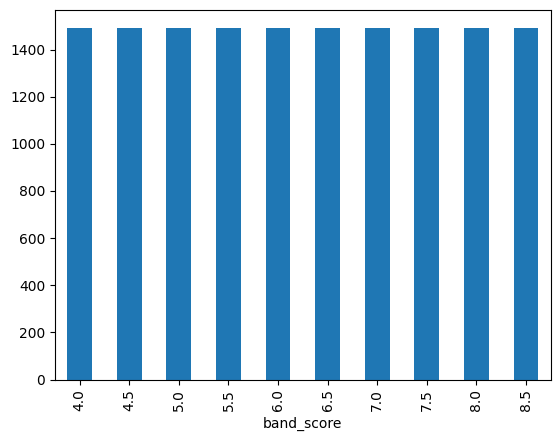

In [6]:
# Apply oversampling to training data only
df_train = random_oversample(df_train, "band_score", random_state=42)

print("\nAfter oversampling:")
print(f"Train shape: {df_train.shape}")
print(
    f"Train class distribution:\n{df_train['band_score'].value_counts().sort_index()}"
)
band_counts = df_train["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")

## Extracting the necessary features

---

In [7]:
X_train_df = df_train[["prompt", "essay"]]
y_train_series = (df_train["band_score"] * 2).astype(int)
X_test_df = df_test[["prompt", "essay"]]
y_test_series = (df_test["band_score"] * 2).astype(int)

## Building the text preprocessing pipeline

---

In [8]:
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

# Load stopwords globally once
ENGLISH_STOPWORDS = set(stopwords.words("english"))


def preprocess_text_fn(text):
    if isinstance(text, str):
        # Convert escape sequences
        text = text.replace("\\\\r\\\\n", " ").replace("\\\\n", " ")
        # Remove special characters and numbers
        text = re.sub(r"[^\\\\w\\\\s]", "", text)
        # Convert to lowercase
        text = text.lower()
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords using the global set
        tokens = [word for word in tokens if word not in ENGLISH_STOPWORDS]
        return " ".join(tokens)
    return ""


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # X is expected to be a pandas Series
        if isinstance(X, pd.Series):
            return X.apply(preprocess_text_fn)
        # If X is a list:
        return pd.Series(X).apply(preprocess_text_fn)

In [9]:
prompt_pipeline = Pipeline(
    [
        ("preprocess", TextPreprocessor()),
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=word_tokenize, lowercase=True, ngram_range=(1, 3), min_df=2
            ),
        ),
    ]
)

essay_pipeline = Pipeline(
    [
        ("preprocess", TextPreprocessor()),
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=word_tokenize, lowercase=True, ngram_range=(1, 3), min_df=2
            ),
        ),
    ]
)

## Vectorizing and concatinating

---

In [10]:
feature_preprocessor = ColumnTransformer(
    transformers=[
        (
            "prompt_features",
            prompt_pipeline,
            "prompt",
        ),
        (
            "essay_features",
            essay_pipeline,
            "essay",
        ),
    ],
    remainder="drop",
)

In [11]:
combined_pipeline = Pipeline(
    [
        ("features", feature_preprocessor),
        ("scaler", StandardScaler(with_mean=False)),
        (
            "logreg",
            LogisticRegression(
                max_iter=1000, random_state=0, multi_class="multinomial", solver="lbfgs"
            ),
        ),
    ]
)

In [12]:
param_grid = {
    "features__prompt_features__tfidf__max_df": [0.9, 0.95],
    "features__prompt_features__tfidf__min_df": [2, 5],
    "features__prompt_features__tfidf__ngram_range": [(1, 2), (1, 3)],
    "features__essay_features__tfidf__max_df": [0.9, 0.95],
    "logreg__C": [0.1, 1, 10, 100],
    "logreg__penalty": ["l2"],
    "logreg__solver": ["lbfgs"],
}

In [13]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    combined_pipeline, param_grid, cv=3, scoring="accuracy", verbose=1, n_jobs=-1
)
grid_search.fit(X_train_df, y_train_series)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Users/finnferchau/dev/team-10/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/finnferchau/dev/team-10/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/finnferchau/dev/team-10/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/finnferchau/dev/team-10/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/finnferchau/dev/team-10/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' 

Best parameters: {'features__essay_features__tfidf__max_df': 0.9, 'features__prompt_features__tfidf__max_df': 0.9, 'features__prompt_features__tfidf__min_df': 2, 'features__prompt_features__tfidf__ngram_range': (1, 2), 'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Best cross-validation score: 0.43295295820581753


In [14]:
best_model = grid_search.best_estimator_

In [15]:
y_pred = best_model.predict(X_test_df)

In [16]:
print("Accuracy:", accuracy_score(y_test_series, y_pred))
print("\nClassification Report:\n", classification_report(y_test_series, y_pred))

Accuracy: 0.5991189427312775

Classification Report:
               precision    recall  f1-score   support

           8       0.93      0.61      0.74        46
           9       0.93      0.81      0.86        31
          10       0.80      0.60      0.69        20
          11       0.92      0.54      0.68        61
          12       0.55      0.58      0.57        67
          13       0.36      0.58      0.45        81
          14       0.46      0.45      0.45        65
          15       0.55      0.57      0.56        46
          16       0.90      0.86      0.88        21
          17       0.94      0.94      0.94        16

    accuracy                           0.60       454
   macro avg       0.73      0.65      0.68       454
weighted avg       0.66      0.60      0.61       454



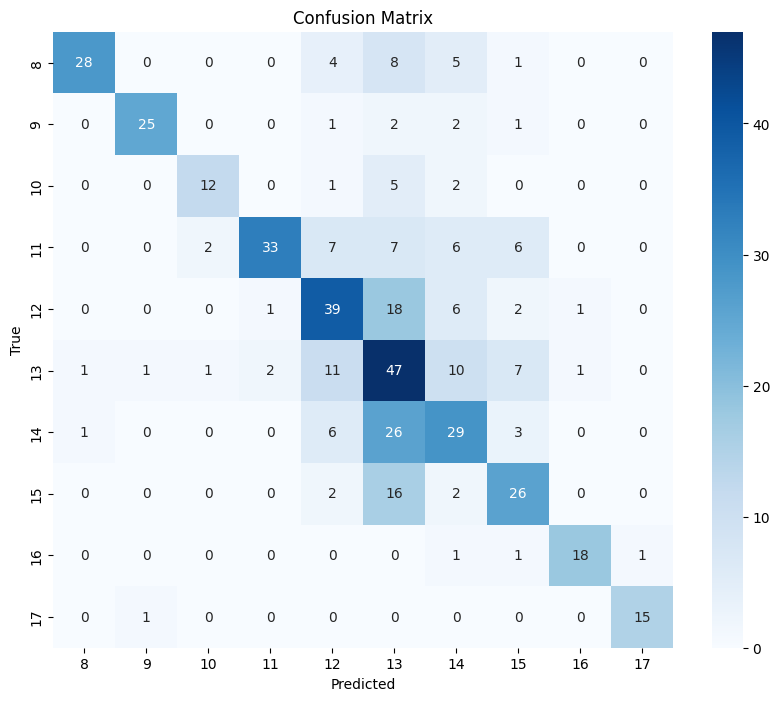

In [17]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_series, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=sorted(y_test_series.unique()),
    yticklabels=sorted(y_test_series.unique()),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### [`Click here to go back to the Homepage`](../Homepage.md)